In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import random
import numpy as np

In [2]:
df_raw = pd.read_csv('dataset/male_players.csv')
df = df_raw.drop(['Unnamed: 0','URL', 'Gender','GK'],axis=1)

### Jika tidak ada player yang mengisi posisi pada formasi?
pisahkan data menjadi 3 bagian lapangan. Depan, Tengah, Belakang <br>
Pemain depan: ['ST', 'CF', 'RW', 'LW']<br>
Pemain tengah: ['CM', 'CDM', 'CAM', 'RM', 'LB', 'RB', 'LM']<br>
Pemain belakang: ['GK', 'CB', 'LWB', 'RWB']


### Genetic Algorithm

In [3]:
# Define functions
def calculate_fitness(individual, target_positions):
    fitness_value = 0
    for player, position in zip(individual, target_positions):
        if player['Position'] == position:
            fitness_value += player['Overall']
    return fitness_value

def tournament_selection(population, fitness_values, tournament_size):
    selected_parents = []
    for _ in range(len(population)):
        tournament_candidates_indices = random.sample(range(len(population)), tournament_size)
        tournament_candidates_fitness = [fitness_values[i] for i in tournament_candidates_indices]
        winner_index = tournament_candidates_indices[np.argmax(tournament_candidates_fitness)]
        selected_parents.append(population[winner_index])
    return selected_parents

def crossover(parent1, parent2, player_data):
    crossover_point = random.randint(0, len(parent1) - 1)
    child1 = parent1[:crossover_point] + parent2[crossover_point:]
    child2 = parent2[:crossover_point] + parent1[crossover_point:]
    
    # Ensure no duplicate players in children
    child1 = remove_duplicates(child1, player_data)
    child2 = remove_duplicates(child2, player_data)

    return child1, child2

def mutate(individual, player_data, mutation_rate):
    for i in range(len(individual)):
        if random.uniform(0, 1) < mutation_rate:
            new_player = random.choice(player_data)
            while new_player['Name'] in [player['Name'] for player in individual]:
                new_player = random.choice(player_data)
            individual[i] = new_player
    return individual

def remove_duplicates(individual, player_data):
    seen_names = set()
    unique_individual = []
    for player in individual:
        if player['Name'] not in seen_names:
            unique_individual.append(player)
            seen_names.add(player['Name'])
    while len(unique_individual) < len(individual):
        new_player = random.choice(player_data)
        while new_player['Name'] in seen_names:
            new_player = random.choice(player_data)
        unique_individual.append(new_player)
        seen_names.add(new_player['Name'])
    return unique_individual

def genetic_algorithm(population, player_data, target_positions, generations, tournament_size, crossover_rate, mutation_rate, pop_size):
    temp_result = []
    best_individual = None
    best_fitness = float('-inf')

    for generation in range(generations):
        fitness_values = [calculate_fitness(individual, target_positions) for individual in population]

        # Keep track of the best individual in the current generation
        max_fitness = max(fitness_values)
        if max_fitness > best_fitness:
            best_fitness = max_fitness
            best_individual = population[np.argmax(fitness_values)]

        # Tournament selection
        parents = tournament_selection(population, fitness_values, tournament_size)

        # Crossover
        children = []
        for parent1, parent2 in zip(parents[::2], parents[1::2] + [None]):
            if parent2 is not None:
                if random.uniform(0, 1) < crossover_rate:
                    child1, child2 = crossover(parent1, parent2, player_data)
                    children.append(child1)
                    children.append(child2)
                else:
                    children.append(parent1)
                    children.append(parent2)
            else:
                # Handle the case where the number of parents is odd
                children.append(parent1)

        # Mutation
        mutated_children = [mutate(child, player_data, mutation_rate) for child in children] 
        # mutated_children = [mutate(individual, player_data, mutation_rate, target_positions) for individual in children] 

        # Combine old and new populations, then select the best individuals
        combined_population = population + mutated_children
        fitness_values_combined = [calculate_fitness(individual, target_positions) for individual in combined_population]
        best_indices_combined = np.argsort(fitness_values_combined)[-pop_size:]
        population = [combined_population[i] for i in best_indices_combined]

        # Print results for each generation
        temp_result.append(best_fitness)
        # print(f"Generation {generation + 1}, Best Fitness: {best_fitness}")
    
    # Pilih individu terbaik dari populasi terakhir
    fitness_values = [calculate_fitness(individual, target_positions) for individual in population]
    best_individual_index = np.argmax(fitness_values)
    best_individual = population[best_individual_index]

    return best_individual, temp_result

### Parameter and Data Selection

In [4]:
formations = {
    "4-3-3": ['GK', 'RB', 'CB', 'CB', 'LB', 'CDM', 'CM', 'CM', 'RW', 'CF', 'LW'],
    "4-4-2": ['GK', 'RB', 'CB', 'CB', 'LB', 'RM', 'CM', 'CM', 'LM', 'CF', 'ST'],
    "3-5-2": ['GK', 'CB', 'CB', 'CB', 'RM', 'CM', 'CDM', 'CAM', 'LM', 'CF', 'ST'],
    "4-2-3-1": ['GK', 'RB', 'CB', 'CB', 'LB', 'CDM', 'CDM', 'CAM', 'RW', 'CF', 'LW'],
    "3-4-3": ['GK', 'CB', 'CB', 'CB', 'RM', 'CM', 'CM', 'LM', 'RW', 'CF', 'LW'],
    "5-3-2": ['GK', 'CB', 'CB', 'CB', 'RWB', 'LWB', 'CM', 'CM', 'CM', 'CF', 'ST'],
    "4-1-4-1": ['GK', 'RB', 'CB', 'CB', 'LB', 'CDM', 'RM', 'CM', 'CM', 'LM', 'CF'],
    "4-5-1": ['GK', 'RB', 'CB', 'CB', 'LB', 'RM', 'CM', 'CM', 'CM', 'LM', 'CF'],
    "3-6-1": ['GK', 'CB', 'CB', 'CB', 'RM', 'CM', 'CM', 'CDM', 'CAM', 'LM', 'CF'],
    "4-3-2-1": ['GK', 'RB', 'CB', 'CB', 'LB', 'CDM', 'CM', 'CM', 'CAM', 'CAM', 'CF'],
    "4-2-2-2": ['GK', 'RB', 'CB', 'CB', 'LB', 'CDM', 'CDM', 'RM', 'LM', 'CF', 'ST'],
    "4-4-1-1": ['GK', 'RB', 'CB', 'CB', 'LB', 'RM', 'CM', 'CM', 'LM', 'CAM', 'CF'],
    "3-4-1-2": ['GK', 'CB', 'CB', 'CB', 'RM', 'CM', 'CM', 'LM', 'CAM', 'CF', 'ST'],
    "3-1-4-2": ['GK', 'CB', 'CB', 'CB', 'CDM', 'RM', 'CM', 'CM', 'LM', 'CF', 'ST'],
    "4-2-1-3": ['GK', 'RB', 'CB', 'CB', 'LB', 'CDM', 'CDM', 'CAM', 'RW', 'CF', 'LW'],
    "5-4-1": ['GK', 'CB', 'CB', 'CB', 'RWB', 'LWB', 'CM', 'CM', 'CM', 'LM', 'CF'],
    "4-1-3-2": ['GK', 'RB', 'CB', 'CB', 'LB', 'CDM', 'RM', 'CM', 'LM', 'CF', 'ST'],
    "3-3-4": ['GK', 'CB', 'CB', 'CB', 'CDM', 'CM', 'CM', 'RW', 'CF', 'ST', 'LW'],
    "4-2-4": ['GK', 'RB', 'CB', 'CB', 'LB', 'CM', 'CM', 'RW', 'CF', 'ST', 'LW'],
    "3-2-3-2": ['GK', 'CB', 'CB', 'CB', 'CDM', 'CM', 'RM', 'CAM', 'LM', 'CF', 'ST']
}
# Mengganti posisi yang sama dengan yang unik
def rename_positions(formation_dict):
    new_formation_dict = {}
    for formation, positions in formation_dict.items():
        position_count = {}
        new_positions = []
        for position in positions:
            if position in position_count:
                position_count[position] += 1
                new_position = f"{position}{position_count[position]}"
            else:
                position_count[position] = 1
                new_position = position
            new_positions.append(new_position)
        new_formation_dict[formation] = new_positions
    return new_formation_dict

# Memanggil fungsi untuk mengganti posisi
unique_formations = rename_positions(formations)

# # Menampilkan hasil
# for formation, positions in unique_formations.items():
#     print(f"{formation}: {positions}")
# Mengubah dict_keys ke list
formations_keys_list = list(unique_formations.keys())
print(formations_keys_list)

['4-3-3', '4-4-2', '3-5-2', '4-2-3-1', '3-4-3', '5-3-2', '4-1-4-1', '4-5-1', '3-6-1', '4-3-2-1', '4-2-2-2', '4-4-1-1', '3-4-1-2', '3-1-4-2', '4-2-1-3', '5-4-1', '4-1-3-2', '3-3-4', '4-2-4', '3-2-3-2']


In [5]:
formation_coordinates = {
    "4-3-3": {
        'GK': (50, 250), 
        'RB': (150, 100), 
        'CB': (200, 200), 
        'CB2': (200, 300), 
        'LB': (150, 400),
        'CDM': (300, 250), 
        'CM': (400, 200), 
        'CM2': (400, 300),
        'RW': (600, 100), 
        'CF': (600, 250), 
        'LW': (600, 400)
    },
    "4-4-2": {
        'GK': (50, 250), 
        'RB': (150, 100), 
        'CB': (200, 200), 
        'CB2': (200, 300), 
        'LB': (150, 400),
        'RM': (400, 100), 
        'CM': (400, 200), 
        'CM2': (400, 300),
        'LM': (400, 400), 
        'CF': (600, 250), 
        'ST': (600, 350)
    },
    "3-5-2": {
        'GK': (50, 250), 
        'CB': (200, 200), 
        'CB2': (200, 300), 
        'CB3': (200, 400),
        'RM': (400, 100), 
        'CM': (400, 200), 
        'CDM': (400, 300), 
        'CAM': (400, 400),
        'LM': (600, 100), 
        'CF': (600, 250), 
        'ST': (600, 350)
    },
    "4-2-3-1": {
        'GK': (50, 250), 
        'RB': (150, 100), 
        'CB': (200, 200), 
        'CB2': (200, 300), 
        'LB': (150, 400),
        'CDM': (300, 250), 
        'CDM2': (300, 350),
        'CAM': (400, 200), 
        'RW': (600, 100), 
        'CF': (600, 250), 
        'LW': (600, 400)
    },
    "3-4-3": {
        'GK': (50, 250), 
        'CB': (200, 200), 
        'CB2': (200, 300), 
        'CB3': (200, 400),
        'RM': (400, 100), 
        'CM': (400, 200), 
        'CM2': (400, 300),
        'LM': (400, 400), 
        'RW': (600, 100), 
        'CF': (600, 250), 
        'LW': (600, 400)
    },
    "5-3-2": {
        'GK': (50, 250), 
        'CB': (200, 200), 
        'CB2': (200, 300), 
        'CB3': (200, 400),
        'RWB': (400, 100), 
        'LWB': (400, 400), 
        'CM': (400, 200), 
        'CM2': (400, 300),
        'CM3': (500, 250), 
        'CF': (600, 250), 
        'ST': (600, 350)
    },
    "4-1-4-1": {
        'GK': (50, 250), 
        'RB': (150, 100), 
        'CB': (200, 200), 
        'CB2': (200, 300), 
        'LB': (150, 400),
        'CDM': (300, 250), 
        'RM': (400, 100), 
        'CM': (400, 200), 
        'CM2': (400, 300),
        'LM': (400, 400), 
        'CF': (600, 250)
    },
    "4-5-1": {
        'GK': (50, 250), 
        'RB': (150, 100), 
        'CB': (200, 200), 
        'CB2': (200, 300), 
        'LB': (150, 400),
        'RM': (400, 100), 
        'CM': (400, 200), 
        'CM2': (400, 300),
        'CM3': (400, 400), 
        'LM': (400, 350), 
        'CF': (600, 250)
    },
    "3-6-1": {
        'GK': (50, 250), 
        'CB': (200, 200), 
        'CB2': (200, 300), 
        'CB3': (200, 400),
        'RM': (400, 100), 
        'CM': (400, 200), 
        'CM2': (400, 300),
        'CDM': (400, 350), 
        'CAM': (500, 200), 
        'LM': (400, 400), 
        'CF': (600, 250)
    },
    "4-3-2-1": {
        'GK': (50, 250), 
        'RB': (150, 100), 
        'CB': (200, 200), 
        'CB2': (200, 300), 
        'LB': (150, 400),
        'CDM': (300, 250), 
        'CM': (400, 200), 
        'CM2': (400, 300),
        'CAM': (500, 200), 
        'CAM2': (500, 300), 
        'CF': (600, 250)
    },
    "4-2-2-2": {
        'GK': (50, 250), 
        'RB': (150, 100), 
        'CB': (200, 200), 
        'CB2': (200, 300), 
        'LB': (150, 400),
        'CDM': (300, 250), 
        'CDM2': (300, 350),
        'RM': (400, 100), 
        'LM': (400, 400), 
        'CF': (600, 250), 
        'ST': (600, 350)
    },
    "4-4-1-1": {
        'GK': (50, 250), 
        'RB': (150, 100), 
        'CB': (200, 200), 
        'CB2': (200, 300), 
        'LB': (150, 400),
        'RM': (400, 100), 
        'CM': (400, 200), 
        'CM2': (400, 300),
        'LM': (400, 400), 
        'CAM': (500, 250), 
        'CF': (600, 250)
    },
    "3-4-1-2": {
        'GK': (50, 250), 
        'CB': (200, 200), 
        'CB2': (200, 300), 
        'CB3': (200, 400),
        'RM': (400, 100), 
        'CM': (400, 200), 
        'CM2': (400, 300),
        'LM': (400, 400), 
        'CAM': (500, 250), 
        'CF': (600, 250), 
        'ST': (600, 350)
    },
    "3-1-4-2": {
        'GK': (50, 250), 
        'CB': (200, 200), 
        'CB2': (200, 300), 
        'CB3': (200, 400),
        'CDM': (300, 250), 
        'RM': (400, 100), 
        'CM': (400, 200), 
        'CM2': (400, 300),
        'LM': (400, 400), 
        'CF': (600, 250), 
        'ST': (600, 350)
    },
    "4-2-1-3": {
        'GK': (50, 250), 
        'RB': (150, 100), 
        'CB': (200, 200), 
        'CB2': (200, 300), 
        'LB': (150, 400),
        'CDM': (300, 250), 
        'CDM2': (300, 350),
        'CAM': (400, 200), 
        'RW': (600, 100), 
        'CF': (600, 250), 
        'LW': (600, 400)
    },
    "5-4-1": {
        'GK': (50, 250), 
        'CB': (200, 200), 
        'CB2': (200, 300), 
        'CB3': (200, 400),
        'RWB': (400, 100), 
        'LWB': (400, 400), 
        'CM': (400, 200), 
        'CM2': (400, 300),
        'CM3': (500, 250), 
        'LM': (400, 350), 
        'CF': (600, 250)
    },
    "4-1-3-2": {
        'GK': (50, 250), 
        'RB': (150, 100), 
        'CB': (200, 200), 
        'CB2': (200, 300), 
        'LB': (150, 400),
        'CDM': (300, 250), 
        'RM': (400, 100), 
        'CM': (400, 200), 
        'LM': (400, 300),
        'CF': (600, 250), 
        'ST': (600, 350)
    },
    "3-3-4": {
        'GK': (50, 250), 
        'CB': (200, 200), 
        'CB2': (200, 300), 
        'CB3': (200, 400),
        'CDM': (300, 250), 
        'CM': (400, 200), 
        'CM2': (400, 300),
        'RW': (600, 100), 
        'CF': (600, 250), 
        'ST': (600, 350), 
        'LW': (600, 400)
    },
    "4-2-4": {
        'GK': (50, 250), 
        'RB': (150, 100), 
        'CB': (200, 200), 
        'CB2': (200, 300), 
        'LB': (150, 400),
        'CM': (400, 200), 
        'CM2': (400, 300),
        'RW': (600, 100), 
        'CF': (600, 250), 
        'ST': (600, 350), 
        'LW': (600, 400)
    },
    "3-2-3-2": {
        'GK': (50, 250), 
        'CB': (200, 200), 
        'CB2': (200, 300), 
        'CB3': (200, 400),
        'CDM': (300, 250), 
        'CM': (400, 200), 
        'RM': (400, 100), 
        'CAM': (500, 250), 
        'LM': (400, 400), 
        'CF': (600, 250), 
        'ST': (600, 350)
    }
}
formations_coordinates_keys_list = list(formation_coordinates.keys())
print(formations_coordinates_keys_list)

['4-3-3', '4-4-2', '3-5-2', '4-2-3-1', '3-4-3', '5-3-2', '4-1-4-1', '4-5-1', '3-6-1', '4-3-2-1', '4-2-2-2', '4-4-1-1', '3-4-1-2', '3-1-4-2', '4-2-1-3', '5-4-1', '4-1-3-2', '3-3-4', '4-2-4', '3-2-3-2']


Individu Terbaik:
Name: Marc-André ter Stegen, Position: GK
Name: Sergi Roberto, Position: RB
Name: Jules Koundé, Position: CB
Name: Ronald Araujo, Position: CB
Name: João Cancelo, Position: LB
Name: Oriol Romeu, Position: CDM
Name: Frenkie de Jong, Position: CM
Name: Pedri, Position: CM
Name: Raphinha, Position: RW
Name: João Félix, Position: CF
Name: Ferran Torres, Position: LW


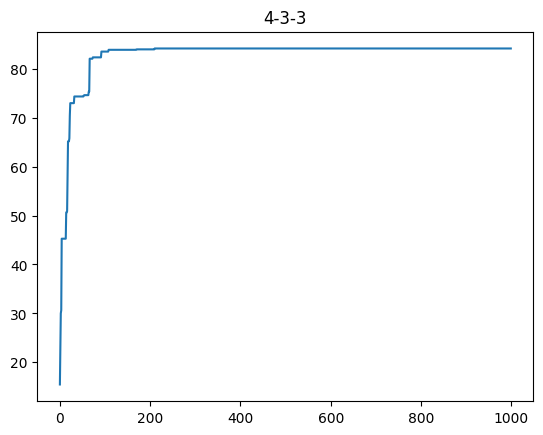

In [22]:
player_club = df[df['Club'] == 'FC Barcelona']
player_data = player_club.to_dict(orient='records')
# player_data = df.to_dict(orient='records')

# Inisialisasi populasi
pop_size = 10
population = []

for _ in range(pop_size):
    # Ambil 11 player secara acak dari player_data
    team = random.sample(player_data, 11)
    population.append(team)

# Inisialisasi populasi
initial_population = population

# Parameter algoritma genetika
team_formation = 0 # select formation
target_positions = formations[formations_keys_list[team_formation]]
generations = 1000
tournament_size = 3
crossover_rate = 0.8
mutation_rate = 0.1

# Jalankan algoritma genetika
result, temp_result = genetic_algorithm(population, player_data, target_positions, generations, tournament_size, crossover_rate, mutation_rate, pop_size)

# Cetak hasil individu terbaik
print("Individu Terbaik:")
best_teams = result
for player in best_teams:
    print(f"Name: {player['Name']}, Position: {player['Position']}")

plt.plot((temp_result/np.float64(1100))*100)
plt.title(formations_keys_list[team_formation])
plt.show()

In [23]:
players_choice = []
for player in best_teams:
    players_choice.append([player['Name'], player['Position']])
# Dictionary to count occurrences of positions
position_count = {}

# Rename positions with numbers
renamed_players = []
for name, position in players_choice:
    # Initialize the count for the position if it doesn't exist
    if position not in position_count:
        position_count[position] = 0
        
    # Increment the position count
    position_count[position] += 1
    # Create the new position name
    new_position = f"{position}{position_count[position]}" if position_count[position] > 1 else position
    
    # Append the renamed player to the list
    renamed_players.append([name, new_position])

# # Output the renamed list
# renamed_players

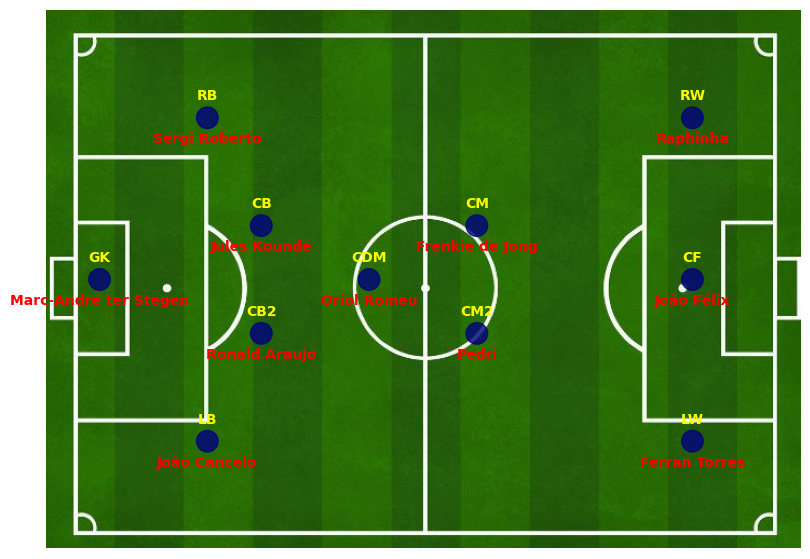

In [24]:
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Formasi dan posisi yang ingin digambarkan
formation = target_positions

# Koordinat x dan y untuk setiap posisi pemain di atas lapangan (dimensi pitch 700x500)
coordinates = formation_coordinates[formations_coordinates_keys_list[team_formation]]

# Pemain yang akan ditempatkan pada posisi tertentu
players = renamed_players

# Memuat gambar lapangan
image_path = 'assets/Lines_On_A_Football_Pitch.jpg'
image = Image.open(image_path)

# Menampilkan gambar dengan matplotlib
fig, ax = plt.subplots(figsize=(10, 7))
ax.imshow(image)

# Ukuran lapangan (asumsi dimensi 700x500)
width, height = 700, 500

# Gambar posisi pemain dan nama pemain
for position, coords in coordinates.items():
    x, y = coords
    # Tambahkan lingkaran di posisi pemain
    circle = patches.Circle((x, y), 10, color='navy', alpha=0.8)
    ax.add_patch(circle)
    # Tambahkan teks posisi pemain (e.g., 'RB')
    ax.text(x, y - 20, position, horizontalalignment='center', verticalalignment='center', color='yellow', fontsize=10, weight='bold')
    # Tambahkan nama pemain (e.g., 'Sergi Roberto')
    # ax.text(x, y + 20, players[position], horizontalalignment='center', verticalalignment='center', color='red', fontsize=10, weight='bold')
    ax.text(x, y + 20, [player[0] for player in players if player[1] == position][0], horizontalalignment='center', verticalalignment='center', color='red', fontsize=10, weight='bold')

# Sesuaikan axis agar sesuai dengan ukuran gambar
ax.set_xlim(0, width)
ax.set_ylim(height, 0)  # Membalik axis y agar cocok dengan gambar

# Hilangkan axis
plt.axis('off')
plt.show()
